In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import xarray as xr
import datetime
import timeit

from power_curve import Lkl_array, create_lkl_from_xls, create_lkl_from_1D_data


# QUICK SOLUTION

I build a single function `create_lkl_from_xls()` to handle the entire xls to netCDF transfer.

This Function will:

1. take all Leistungskennlinien inside the passed `.xls` file and structure them inside a `xarray.Dataarray`
2. interpolate them to the increment size of the Windatlas data,
3. extend the lkl's Windspeed to 0,
4. export the collection of lkl-Arrays to a netCDF-File

In [ ]:
create_lkl_from_xls(
    xls_path = "/home/eouser/Documents/code/Windatlas/windatlas/anemos_data/wea_data/raw_data/WEA_Vestas.xls",
    output_path = "/home/eouser/Documents/code/Windatlas/windatlas/anemos_data/wea_data/data/vestas_lkl.nc",
)

### load all lkl data into single netCDF

In [2]:
base = "/home/eouser/Documents/code/Windatlas/windatlas/anemos_data/wea_data/raw_data"
for file in os.listdir(base):
    if file.endswith("REpower.xls"):
        abs_file_path = os.path.join(base, file)
        print(file.lower().split(".")[0])
        test = create_lkl_from_xls(
                xls_path = abs_file_path,
                output_path = f"/uba/anemos_winddata/powercurves/single_netcdfs/{file.lower().split('.')[0]}.nc",
                power_limiter=True,
                wspd_to_zero=True,
            )

wea_repower


In [3]:
data = xr.open_mfdataset("/uba/anemos_winddata/powercurves/single_netcdfs/wea_*.nc", parallel=True, engine="h5netcdf", combine="nested", concat_dim="wea_type")

#data.sel(wea_type='SWT_120_3.6').power.plot()

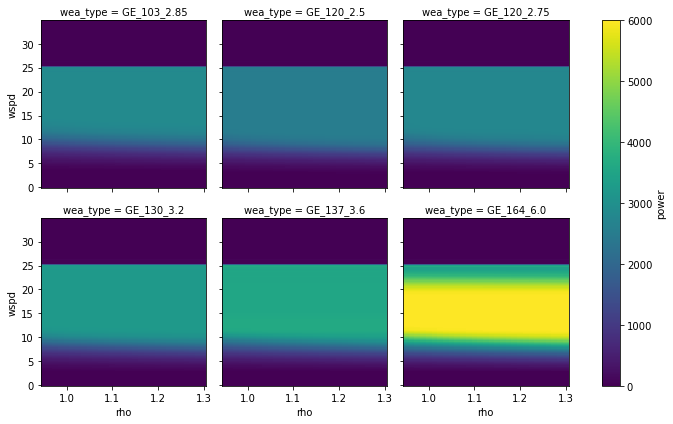

In [6]:
wspd_plot = np.arange(data.wspd.min().values,data.wspd.max().values,0.25)
rho_plot = np.arange(data.rho.min().values,data.rho.max().values,0.0125)
weas = data.wea_type.values[np.char.find(data.wea_type.values.astype("str"), "GE") != -1]
data_plot = data.interp(wspd=wspd_plot, rho=rho_plot).sel(wea_type=weas)

fg = data_plot.power.plot(
    col="wea_type",
    col_wrap=3,  # each row has a maximum of 4 columns
)

In [ ]:
fig = fg.get_figure()
fig.savefig("enercon.png",format="png")

### Controll Read of lkl netCDF

In [9]:
output_path = "/uba/anemos_winddata/powercurves/single_netcdfs/wea_*.nc"
test = xr.open_mfdataset(output_path, parallel=True, engine="h5netcdf", combine="nested", concat_dim="wea_type")
test

<xarray.Dataset>
Dimensions:   (wspd: 35001, rho: 3501, wea_type: 63)
Coordinates:
  * wspd      (wspd) float64 0.0 0.001 0.002 0.003 0.004 ... 35.0 35.0 35.0 35.0
  * rho       (rho) float64 0.95 0.9501 0.9502 0.9503 0.9504 ... 1.3 1.3 1.3 1.3
  * wea_type  (wea_type) object 'WEA_beispiel' ... 'Vestas_V-162_6.0'
Data variables:
    power     (wea_type, wspd, rho) float64 dask.array<chunksize=(1, 35001, 3501), meta=np.ndarray>

In [12]:
test.sel(wea_type='Vestas_V-162_6.0').load().sel(wspd=14, rho=1.23, method="nearest").power.values#.to_array().where(test.rho <= 1.3, drop=True).drop(labels=("wea_type")).sel(variable="__xarray_dataarray_variable__").plot(figsize=(15,12))#.surface()#.pcolormesh("wspd", "rho")

array(6000.)

# Step by Step 
## Load example Data

first loading `.xls` with all new *Leistungskennlinien* to `pandas` 

In [ ]:
xls = pd.ExcelFile("/home/eouser/Documents/code/Windatlas/windatlas/anemos_data/wea_data/raw_data/WEA_Vestas.xls", engine="xlrd")
xls.sheet_names

In [ ]:
lkl_dict = dict()

for sheet in xls.sheet_names:
    lkl_dict[sheet] = pd.read_excel(xls, sheet, index_col=0)

for key in lkl_dict:
    if key in ['WEA_beispiel']:
        continue
    print(key)
    lkl_dict[key] = create_lkl_from_1D_data(target_lkl=lkl_dict[key])
    lkl_dict[key] = lkl_dict[key].fillna(0)

lkl_dict[key]

In [ ]:
lkl_dict['WEA_beispiel']

In [ ]:

lkl_dict["Vestas_V-110_2.0"].index.max()

In [ ]:
rel_bsp

## Transforming the *Leistungskennlinie* to a *Windatlas* compatible format by building a `xarray` from `pandas` 

In [ ]:
for key in lkl_dict:
    data_vars={'leistung':(['wspd','rho'], np.array(lkl_dict[key]), 
                            {'units': 'kWh',
                            'long_name':'Leistung aus Wind und Luftdichte'})}

    coords = {
            "wspd": (["wspd"], np.array(lkl_dict[key].index, dtype="float64")),
            "rho": (["rho"], np.array(lkl_dict[key].columns, dtype="float64")),
            }

    attrs = {#'wea_type':key,
            'describtion':"interpolated Leistungskennlinie",
            'creation_date':str(datetime.date.today()), 
            'author':'Claudius Wehner'}

    lkl_dict[key] = xr.DataArray(
        data=np.array(lkl_dict[key]),
        coords=coords,
        attrs=attrs
    )

lkl_dict[key]

## Interpolation

Interpolation is done using the scipy.interpolation package for both 1D and 2D interpolation of wind turbine power delivery data.
Examples for the here used methods can be found online:
https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html#d-spline-representation-object-oriented-bivariatespline

### Example with plots for one lkl

In [ ]:
import matplotlib.pyplot as plt

increment_wspd = 0.001
increment_rho = 0.0001
power_limiter = True

fig, axes = plt.subplots(ncols=2, figsize=(16, 7))
lkl_dict[key].plot(ax=axes[0])
axes[0].set_title("Raw Leistungskennlinie")

new_wspd = np.arange(lkl_dict[key].wspd[0], lkl_dict[key].wspd[-1]+increment_wspd, increment_wspd, dtype=np.float64)
new_rho = np.arange(lkl_dict[key].rho[0], lkl_dict[key].rho[-1]+increment_rho, increment_rho, dtype=np.float64)
testarray2Di = lkl_dict[key].interp(wspd=new_wspd, rho=new_rho, method="quadratic")

#### GOLDEN STEP TO MAKE .sel() WORK AFTER INTERPOLATION ####
# Reassigning helps solving the rounding error
testarray2Di = testarray2Di.assign_coords(
            coords={
                "wspd": testarray2Di.wspd.round(decimals=3),
                "rho": testarray2Di.rho.round(decimals=4)}
        )
#############################################################
if power_limiter:
    maxOriginalPower = lkl_dict[key].max()
    testarray2Di = testarray2Di.where(testarray2Di < maxOriginalPower, other = maxOriginalPower)
    testarray2Di = testarray2Di.where(testarray2Di > 0, other = 0)


testarray2Di.plot(ax=axes[1])
axes[1].set_title("Interpolated Leistungskennlinie")

### Interpolating all arrays in lkl_dict

In [ ]:
increment_wspd = 0.001
increment_rho = 0.0001
power_limiter = True

for key in lkl_dict:
    new_wspd = np.arange(lkl_dict[key].wspd[0], lkl_dict[key].wspd[-1]+increment_wspd, increment_wspd, dtype=np.float64)
    new_rho = np.arange(lkl_dict[key].rho[0], lkl_dict[key].rho[-1]+increment_rho, increment_rho, dtype=np.float64)
    testarray2Di = lkl_dict[key].interp(wspd=new_wspd, rho=new_rho, method="quadratic")

    #### GOLDEN STEP TO MAKE .sel() WORK AFTER INTERPOLATION ####
    # Reassigning helps solving the rounding error
    testarray2Di = testarray2Di.assign_coords(
                coords={
                    "wspd": testarray2Di.wspd.round(decimals=3),
                    "rho": testarray2Di.rho.round(decimals=4)}
            )
    #############################################################
    if power_limiter:
        maxOriginalPower = lkl_dict[key].max()
        testarray2Di = testarray2Di.where(testarray2Di < maxOriginalPower, other = maxOriginalPower)
        testarray2Di = testarray2Di.where(testarray2Di > 0, other = 0)
    
    lkl_dict[key] = testarray2Di

### Example Plot for Power Limiter

In [ ]:
maxOriginalPower = lkl_dict[key].max()
 
fig, axes = plt.subplots(ncols=2, figsize=(16, 7))
testarray2Di.isel(rho=7).plot(ax=axes[0])
axes[0].set_title("interpolated Leistungskennlinie")

test = testarray2Di.where(testarray2Di < maxOriginalPower, other = maxOriginalPower)

test.isel(rho=7).plot(ax=axes[1])
axes[1].set_title("Cut interpolated Leistungskennlinie")

In [ ]:
lkl_dict[key]

## Concatination and Export

In [ ]:
concatinated = xr.concat(lkl_dict.values(), pd.Index(lkl_dict.keys(), name="wea_type"))
concatinated.sel(wea_type="WEA_beispiel")

In [ ]:
#concatinated.to_netcdf(path = "data/wea_lkl.nc", mode="w")

# Test calculation of power output

In [ ]:
test = xr.open_mfdataset("/uba/anemos_winddata/powercurves/single_netcdfs/wea_*.nc", parallel=True, engine="h5netcdf", combine="nested", concat_dim="wea_type")

test.sel(wea_type="Vestas_V-110_2.0")

In [ ]:
size = 525888
time = np.arange(0,size,1)
wspd = np.around(np.random.uniform(float(test.wspd.min()), float(test.wspd.max()), size=size),1)#.astype(np.float64)
rho = np.around(np.random.uniform(float(test.rho.min()), float(test.rho.max()), size=size),3)#.astype(np.float64)
start = timeit.default_timer()
#### GOLDEN STEP ####
dummy = test.sel(wea_type="WEA_beispiel").load().sel(
    wspd=xr.DataArray(wspd, dims='wea'), 
    rho=xr.DataArray(rho, dims='wea'), 
    method="nearest")# if error appears, use method="nearest"
#####################
end = timeit.default_timer()
timed = end - start
del(wspd)
del(rho)
print(f'Time to get {size} "leistungs"-values from equivalent wspd and rho time series data: {timed}')
dummy#.plot.scatter(y="__xarray_dataarray_variable__", x=time)#.to_numpy()/ 6 #[:100]

In [ ]:
path = f"/uba/anemos_winddata/20191029_anemosDataFull/UBA-Windatlas/TSNC-Format/wspd.10L.*.ts.nc"
data = xr.open_mfdataset(path, engine='h5netcdf', parallel=True)

start = str(2009) 
end = str(2018)
data = data.sel(time=slice(start, end))

data.time.values

In [ ]:
df = dummy.to_pandas()#.to_frame()
df = df.rename({0: "Eout"}, axis=1)
df = df.set_index(data.time.values)
#df["wspd"] = dummy.wspd.values
#df["rho"] = dummy.rho.values *10
#df.loc[:,"leistung"] = df["leistung"] /100
df.power.resample("7d").mean().plot(figsize=(20,5))

# OUTDATED! NOW SINGLE FUNCTION AT THE TOP OF THE NOTEBOOK
## Use of the Lkl_array class

In [ ]:
test_wea = Lkl_array(
    source_csv = 'example/WEA_beispiel.csv',  
)
test_wea.lkl_interpolate(
    increment_wspd=0.001,
    increment_rho = 0.0001,
)
path = "example/test_wea.nc"
test_wea.to_netcdf(path=path, name_if_dataarray="test_wea")

xr.open_dataset(path, engine='h5netcdf')